In [150]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import os
import scipy.stats as sts
from scipy.stats import linregress

%matplotlib inline

# Data Directory
data_loc = "Resources"

# Output Directory
output_data_loc = "Output"

# Data File (CSV)
data_file_path = f"{data_loc}/spotify_dataset.csv"

In [151]:
# Read into DataFrame
data_df = pd.read_csv(data_file_path)

data_df.shape

(1556, 23)

In [152]:
# Update any blank cells to be nan so the rows can be dropped - we only want records with all the metrics intact
data_df.replace("", np.nan, inplace=True)
data_df.replace(" ", np.nan, inplace=True)

# Delete any records with null values
data_df = data_df.dropna()

data_df.shape


(1545, 23)

In [153]:
# Remove duplicate songs

print(data_df[data_df.duplicated(subset=['Song ID'])].shape)
data_df.drop_duplicates(subset=['Song ID'], inplace=True)
print(data_df[data_df.duplicated(subset=['Song ID'])].shape)
print(data_df.shape)


(29, 23)
(0, 23)
(1516, 23)


In [154]:
# Check the types - what do we need to convert for processing?
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1516 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1516 non-null   int64 
 1   Highest Charting Position  1516 non-null   int64 
 2   Number of Times Charted    1516 non-null   int64 
 3   Week of Highest Charting   1516 non-null   object
 4   Song Name                  1516 non-null   object
 5   Streams                    1516 non-null   object
 6   Artist                     1516 non-null   object
 7   Artist Followers           1516 non-null   object
 8   Song ID                    1516 non-null   object
 9   Genre                      1516 non-null   object
 10  Release Date               1516 non-null   object
 11  Weeks Charted              1516 non-null   object
 12  Popularity                 1516 non-null   object
 13  Danceability               1516 non-null   object
 14  Energy  

In [155]:
# Popularity - Create a data set removing unwanted records and converting field types to desired types
popularity_df = data_df.copy()
popularity_df['Popularity']=popularity_df['Popularity'].astype(int)

popularity_df['Streams']=popularity_df['Streams'].replace(',','', regex=True)
popularity_df['Streams']=popularity_df['Streams'].astype(int)

# Update these dataframe data types and round for better plotting
popularity_df['Danceability']=popularity_df['Danceability'].astype(float).round(2)
popularity_df['Energy']=popularity_df['Energy'].astype(float).round(2)
popularity_df['Tempo']=popularity_df['Tempo'].astype(float).round(0)
popularity_df['Valence']=popularity_df['Valence'].astype(float).round(2)
popularity_df['Duration (ms)']=popularity_df['Duration (ms)'].astype(int)
popularity_df['Loudness']=popularity_df['Loudness'].astype(float).round(2)


In [156]:
# Remove all songs with 0 popularity
idxs = popularity_df[popularity_df['Popularity']==0].index
popularity_df.drop(idxs, inplace=True)
popularity_df.loc[popularity_df['Popularity']==0]


,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord


In [157]:
# Separate out genres so there is one genre per record

# copy the data into a new set to manipulate for genre
genre_df = popularity_df.copy()

# Convert from object to string
genre_df['Genre']=genre_df['Genre'].astype(str)

# Find records that have no Genres and set them to 0
genre_df.loc[genre_df["Genre"] == "[]", "Genre"] = np.nan
genre_df["Genre"] = genre_df["Genre"].fillna(0)

# Remove unneccessary characters
genre_df["Genre"] = genre_df["Genre"].str.replace("[", "", regex=True)
genre_df["Genre"] = genre_df["Genre"].str.replace("]", "", regex=True)
genre_df["Genre"] = genre_df["Genre"].str.replace("'", "", regex=True)

# Split on commas
genre_df["Genre"] = genre_df["Genre"].str.split(",")

# separte and create rows based on genres. There will now be a row for each 
# genre a given song has so we can easily create charts based on genre
genre_df = genre_df.explode('Genre')

# Now we have all the separete records, clean up white space issues that make things like "pop" and "  pop" get counted differently.
genre_df["Genre"] = genre_df["Genre"].str.strip()

# Render
genre_df.head()
#genre_df.columns

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',48633449,Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,indie rock italiano,...,0.71,0.80,-4.81,0.0504,0.127,0.359,134.0,211560,0.59,B
0,1,1,8,2021-07-23--2021-07-30,Beggin',48633449,Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,italian pop,...,0.71,0.80,-4.81,0.0504,0.127,0.359,134.0,211560,0.59,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),47248719,The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,australian hip hop,...,0.59,0.76,-5.48,0.0483,0.0383,0.103,170.0,141806,0.48,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,40162559,Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,pop,...,0.56,0.66,-5.04,0.154,0.335,0.0849,167.0,178147,0.69,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,37799456,Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,pop,...,0.81,0.90,-3.71,0.0348,0.0469,0.364,126.0,231041,0.59,B


array([<AxesSubplot:>], dtype=object)

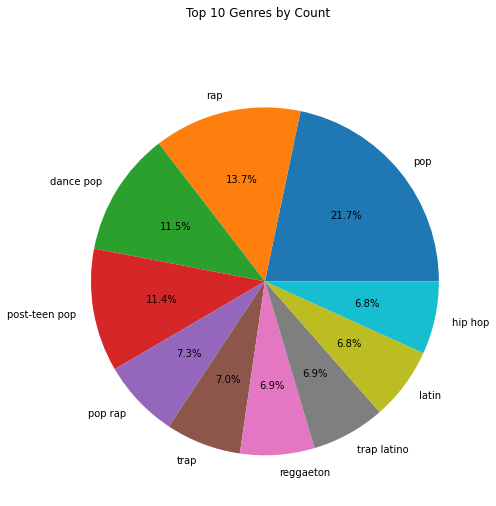

In [158]:
# Genereate pie chart for top 10 most popular genres based on the value count
genre_df['Genre'].value_counts()[:10].plot.pie(subplots=True, 
                                               ylabel="", 
                                               title="Top 10 Genres by Count", 
                                               autopct='%1.1f%%', 
                                               figsize=(8,8))


In [178]:
# Determine the top genres based on popularity and streams

top10 = genre_df[['Song Name', 'Popularity', 'Streams', 'Genre']].nlargest(10, ['Popularity','Streams'])
top10

,Song Name,Popularity,Streams,Genre
0,Beggin',100,48633449,indie rock italiano
0,Beggin',100,48633449,italian pop
1,STAY (with Justin Bieber),99,47248719,australian hip hop
2,good 4 u,99,40162559,pop
3,Bad Habits,98,37799456,pop
3,Bad Habits,98,37799456,uk pop
5,MONTERO (Call Me By Your Name),97,30071134,lgbtq+ hip hop
5,MONTERO (Call Me By Your Name),97,30071134,pop rap
4,INDUSTRY BABY (feat. Jack Harlow),96,33948454,lgbtq+ hip hop
4,INDUSTRY BABY (feat. Jack Harlow),96,33948454,pop rap


array([<AxesSubplot:>], dtype=object)

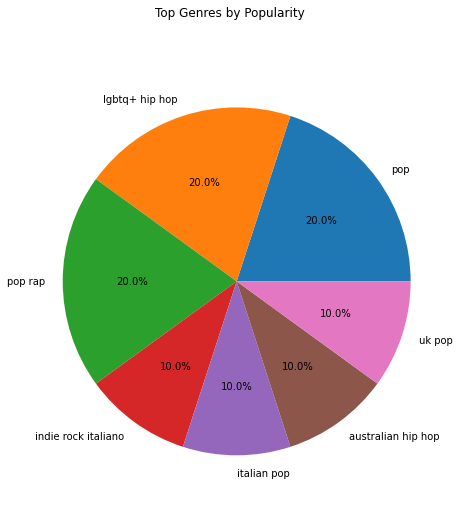

In [179]:
# Pie chart it

top10['Genre'].value_counts().plot.pie(subplots=True, 
                                               ylabel="", 
                                               title="Top Genres by Popularity", 
                                               autopct='%1.1f%%', 
                                               figsize=(8,8))

In [161]:
# Popularity appears to be directly attributed to the number of streams...

top10 = popularity_df[['Song Name', 'Popularity', 'Streams', 'Genre']].nlargest(10, ['Popularity','Streams'])
top10

,Song Name,Popularity,Streams,Genre
0,Beggin',100,48633449,"['indie rock italiano', 'italian pop']"
1,STAY (with Justin Bieber),99,47248719,['australian hip hop']
2,good 4 u,99,40162559,['pop']
3,Bad Habits,98,37799456,"['pop', 'uk pop']"
5,MONTERO (Call Me By Your Name),97,30071134,"['lgbtq+ hip hop', 'pop rap']"
4,INDUSTRY BABY (feat. Jack Harlow),96,33948454,"['lgbtq+ hip hop', 'pop rap']"
8,Yonaguni,96,25030128,"['latin', 'reggaeton', 'trap latino']"
7,Todo De Ti,95,26951613,"['puerto rican pop', 'trap latino']"
9,I WANNA BE YOUR SLAVE,95,24551591,"['indie rock italiano', 'italian pop']"
11,Qué Más Pues?,95,22405111,"['latin', 'reggaeton', 'reggaeton colombiano']"


In [162]:
# Popularity appears to be directly attributed to the number of streams...

top10 = popularity_df[['Song Name', 'Popularity', 'Streams', 'Genre']].nlargest(10, ['Popularity'])
top10

,Song Name,Popularity,Streams,Genre
0,Beggin',100,48633449,"['indie rock italiano', 'italian pop']"
1,STAY (with Justin Bieber),99,47248719,['australian hip hop']
2,good 4 u,99,40162559,['pop']
3,Bad Habits,98,37799456,"['pop', 'uk pop']"
5,MONTERO (Call Me By Your Name),97,30071134,"['lgbtq+ hip hop', 'pop rap']"
4,INDUSTRY BABY (feat. Jack Harlow),96,33948454,"['lgbtq+ hip hop', 'pop rap']"
8,Yonaguni,96,25030128,"['latin', 'reggaeton', 'trap latino']"
7,Todo De Ti,95,26951613,"['puerto rican pop', 'trap latino']"
9,I WANNA BE YOUR SLAVE,95,24551591,"['indie rock italiano', 'italian pop']"
11,Qué Más Pues?,95,22405111,"['latin', 'reggaeton', 'reggaeton colombiano']"


In [163]:

# function to calculate linear regression values and return them along with the line equation after printing the r value
def calcLinregress(x_vals, y_vals):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
    regress_values = x_vals * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    return regress_values, line_eq, rvalue
        
    
# function to generate basic dashboard
def genereateDashboard(x_vals, y_vals, xlabel, ylabel, regress_values, line_eq, x_annotate, y_annotate, file_path="") :
    
    # plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].grid(True)
    axs[0].plot(x_vals,regress_values,"r-")    
    axs[0].annotate(line_eq,(x_annotate,y_annotate),fontsize=15,color="red")
    axs[0].scatter(x_vals,y_vals, edgecolors='k')    
    axs[1].hist(x_vals)    
    axs[2].boxplot(y_vals)
    
    # labels
    fig.suptitle(f'{xlabel} vs. {ylabel}')
    axs[0].set_xlabel(xlabel)
    axs[1].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[1].set_ylabel("Count")
    axs[2].set_ylabel(ylabel) 
    
    # Save to png file
    if file_path != "": plt.savefig(file_path)
        
    plt.show()        
        
# function to print out stats for figures
def generateStatsReport(r_val, x_src, y_src, x_label, y_label) :
    
    print("")
    print(f"The r-value is: {round(r_val,2)}")
    
    print("")
    print("---------------------------------------------------------------------")
    print("")

    mean_numpy = np.mean(x_src)
    print(f"The mean {x_label} is {round(mean_numpy,2)}")

    median_numpy = np.median(x_src)
    print(f"The median {x_label} is {round(median_numpy,2)}")

    mode_scipy = sts.mode(x_src)
    print(f"The mode {x_label} is {mode_scipy}")

    print("")

    print(f"Disribution results for 50 samples for {x_label}: {sts.normaltest(x_src.sample(50))}")

    print("")
    print("---------------------------------------------------------------------")
    print("")

    # Demonstrate calculating the variance and standard deviation using the different modules
    var_numpy = np.var(x_src,ddof = 0)
    print(f"The {x_label} variance is approx. {round(var_numpy,2)}")

    sd_numpy = np.std(x_src,ddof = 0)
    print(f"The {x_label} standard deviation is approx. {round(sd_numpy,2)}")

    # Calculate the 68-95-99.7 rule using the standard deviation
    print(f"Roughly 68% of the data is between {round(mean_numpy-sd_numpy,2)} and {round(mean_numpy+sd_numpy,2)}")
    print(f"Roughly 95% of the data is between {round(mean_numpy-2*sd_numpy,2)} and {round(mean_numpy+2*sd_numpy,2)}")
    print(f"Roughly 99.7% of the data is between {round(mean_numpy-3*sd_numpy,2)} and {round(mean_numpy+3*sd_numpy,2)}")

    print("")
    print("---------------------------------------------------------------------")
    print("")

    quartiles = y_src.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq

    print(f"The lower quartile of {y_label} is: {lowerq}")
    print(f"The upper quartile of {y_label} is: {upperq}")
    print(f"The interquartile range of {y_label} is: {iqr}")
    print(f"The the median of {y_label} is: {quartiles[0.5]} ")

    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    

In [164]:



# Pull out specific field data for processing
popularity = popularity_df["Popularity"]
danceability = popularity_df["Danceability"]
energy = popularity_df["Energy"]
tempo = popularity_df["Tempo"]
valence = popularity_df["Valence"]
duration = popularity_df["Duration (ms)"]
loudness = popularity_df["Loudness"]


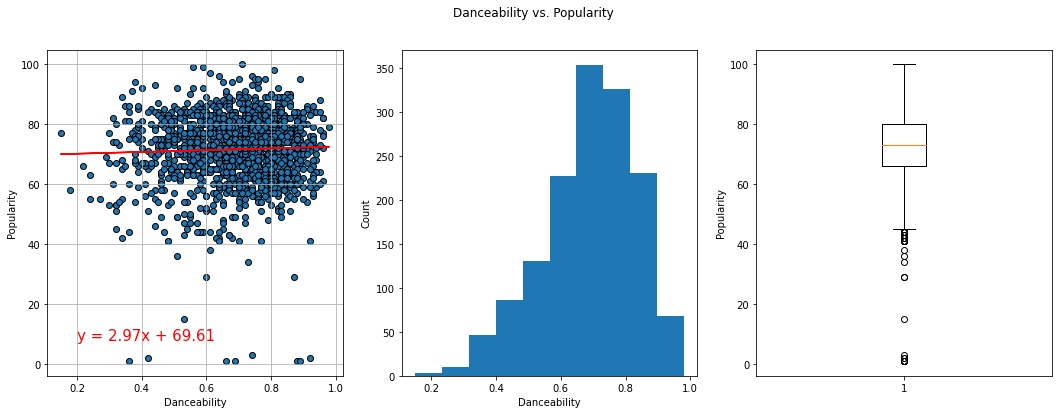


The r-value is: 0.04

---------------------------------------------------------------------

The mean Danceability is 0.69
The median Danceability is 0.71
The mode Danceability is ModeResult(mode=array([0.76]), count=array([52]))

Disribution results for 50 samples for Danceability: NormaltestResult(statistic=2.126924736793389, pvalue=0.3452583269421237)

---------------------------------------------------------------------

The Danceability variance is approx. 0.02
The Danceability standard deviation is approx. 0.14
Roughly 68% of the data is between 0.55 and 0.83
Roughly 95% of the data is between 0.4 and 0.97
Roughly 99.7% of the data is between 0.26 and 1.12

---------------------------------------------------------------------

The lower quartile of Popularity is: 66.0
The upper quartile of Popularity is: 80.0
The interquartile range of Popularity is: 14.0
The the median of Popularity is: 73.0 
Values below 45.0 could be outliers.
Values above 101.0 could be outliers.


In [165]:
# Popularity vs. Danceability

# Calculate regression values and the line equation
reg_vals, ln_eq, r_val = calcLinregress(danceability, popularity)

# Render the dashboard 
genereateDashboard(
    danceability, 
    popularity, 
    "Danceability", 
    "Popularity", 
    reg_vals, 
    ln_eq, 
    0.2,
    8,
    f"{output_data_loc}/Danceability_vs_Popularity.png")

# Render the stats data report
generateStatsReport(r_val, danceability, popularity, "Danceability", "Popularity")


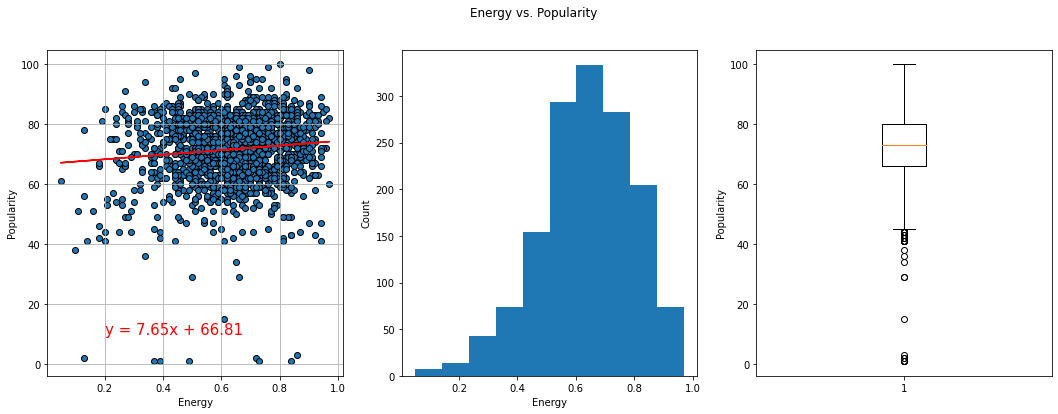


The r-value is: 0.11

---------------------------------------------------------------------

The mean Energy is 0.63
The median Energy is 0.64
The mode Energy is ModeResult(mode=array([0.62]), count=array([48]))

Disribution results for 50 samples for Energy: NormaltestResult(statistic=12.272313548088059, pvalue=0.00216322141161445)

---------------------------------------------------------------------

The Energy variance is approx. 0.03
The Energy standard deviation is approx. 0.16
Roughly 68% of the data is between 0.47 and 0.79
Roughly 95% of the data is between 0.31 and 0.96
Roughly 99.7% of the data is between 0.15 and 1.12

---------------------------------------------------------------------

The lower quartile of Popularity is: 66.0
The upper quartile of Popularity is: 80.0
The interquartile range of Popularity is: 14.0
The the median of Popularity is: 73.0 
Values below 45.0 could be outliers.
Values above 101.0 could be outliers.


In [166]:
# Popularity vs. Energy

# Calculate regression values and the line equation
reg_vals, ln_eq, r_val = calcLinregress(energy, popularity)

# Render the dashboard 
genereateDashboard(
    energy, 
    popularity, 
    "Energy", 
    "Popularity", 
    reg_vals, 
    ln_eq,
    0.2,
    10,
    f"{output_data_loc}/Energy_vs_Popularity.png")

# Render the stats data report
generateStatsReport(r_val, energy, popularity, "Energy", "Popularity")


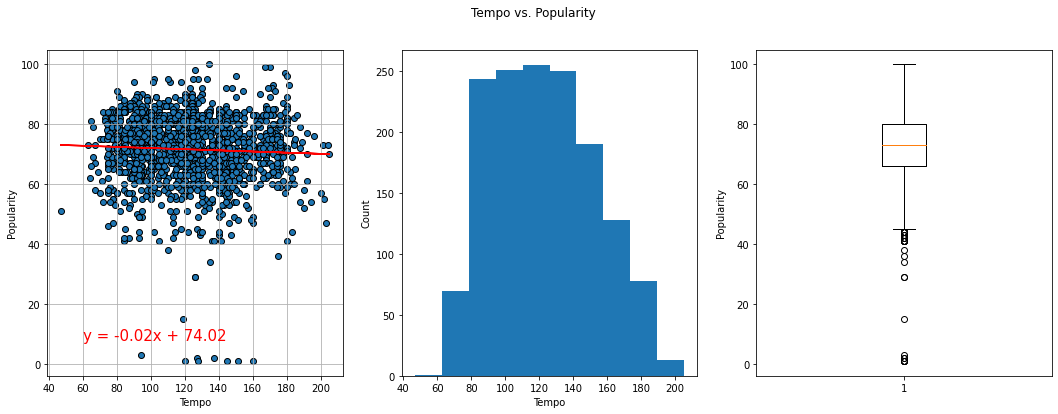


The r-value is: -0.05

---------------------------------------------------------------------

The mean Tempo is 122.78
The median Tempo is 122.0
The mode Tempo is ModeResult(mode=array([140.]), count=array([46]))

Disribution results for 50 samples for Tempo: NormaltestResult(statistic=3.4971169607866526, pvalue=0.17402462263312757)

---------------------------------------------------------------------

The Tempo variance is approx. 880.8
The Tempo standard deviation is approx. 29.68
Roughly 68% of the data is between 93.1 and 152.46
Roughly 95% of the data is between 63.42 and 182.13
Roughly 99.7% of the data is between 33.74 and 211.81

---------------------------------------------------------------------

The lower quartile of Popularity is: 66.0
The upper quartile of Popularity is: 80.0
The interquartile range of Popularity is: 14.0
The the median of Popularity is: 73.0 
Values below 45.0 could be outliers.
Values above 101.0 could be outliers.


In [167]:
# Popularity vs. Tempo

# Calculate regression values and the line equation
reg_vals, ln_eq, r_val = calcLinregress(tempo, popularity)

# Render the dashboard 
genereateDashboard(
    tempo, 
    popularity, 
    "Tempo", 
    "Popularity", 
    reg_vals, 
    ln_eq, 
    60,
    8,
    f"{output_data_loc}/Tempo_vs_Popularity.png")

# Render the stats data report
generateStatsReport(r_val, tempo, popularity, "Tempo", "Popularity")


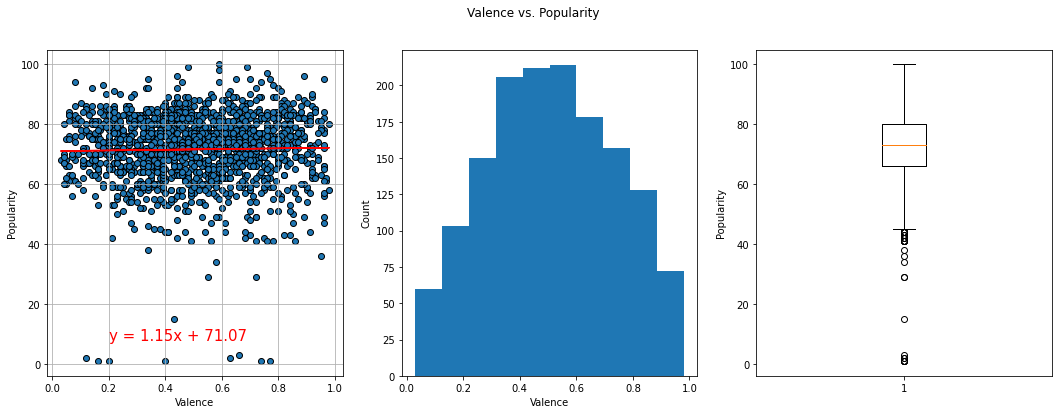


The r-value is: 0.02

---------------------------------------------------------------------

The mean Valence is 0.51
The median Valence is 0.51
The mode Valence is ModeResult(mode=array([0.44]), count=array([28]))

Disribution results for 50 samples for Valence: NormaltestResult(statistic=4.119864790764452, pvalue=0.12746258666300264)

---------------------------------------------------------------------

The Valence variance is approx. 0.05
The Valence standard deviation is approx. 0.23
Roughly 68% of the data is between 0.29 and 0.74
Roughly 95% of the data is between 0.06 and 0.96
Roughly 99.7% of the data is between -0.17 and 1.19

---------------------------------------------------------------------

The lower quartile of Popularity is: 66.0
The upper quartile of Popularity is: 80.0
The interquartile range of Popularity is: 14.0
The the median of Popularity is: 73.0 
Values below 45.0 could be outliers.
Values above 101.0 could be outliers.


In [168]:
# Popularity vs. Valence

# Calculate regression values and the line equation
reg_vals, ln_eq, r_val = calcLinregress(valence, popularity)

# Render the dashboard 
genereateDashboard(
    valence, 
    popularity, 
    "Valence", 
    "Popularity", 
    reg_vals, 
    ln_eq, 
    0.2,
    8,
    f"{output_data_loc}/Valence_vs_Popularity.png")

# Render the stats data report
generateStatsReport(r_val, valence, popularity, "Valence", "Popularity")


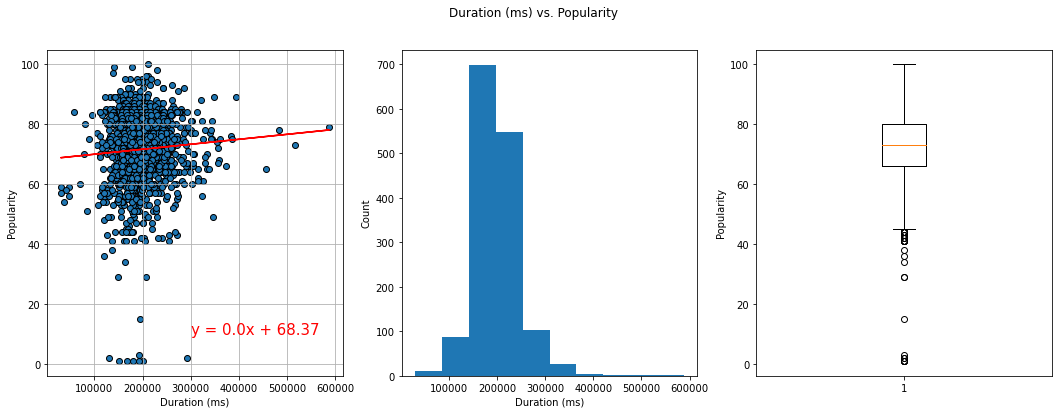


The r-value is: 0.07

---------------------------------------------------------------------

The mean Duration (ms) is 198171.09
The median Duration (ms) is 193684.0
The mode Duration (ms) is ModeResult(mode=array([180000]), count=array([3]))

Disribution results for 50 samples for Duration (ms): NormaltestResult(statistic=7.460160535890079, pvalue=0.023990910058371052)

---------------------------------------------------------------------

The Duration (ms) variance is approx. 2213787306.29
The Duration (ms) standard deviation is approx. 47050.9
Roughly 68% of the data is between 151120.19 and 245221.99
Roughly 95% of the data is between 104069.29 and 292272.89
Roughly 99.7% of the data is between 57018.39 and 339323.8

---------------------------------------------------------------------

The lower quartile of Popularity is: 66.0
The upper quartile of Popularity is: 80.0
The interquartile range of Popularity is: 14.0
The the median of Popularity is: 73.0 
Values below 45.0 could be 

In [169]:
#Popularity vs. Duration (ms)

# Calculate regression values and the line equation
reg_vals, ln_eq, r_val = calcLinregress(duration, popularity)


# Render the dashboard 
genereateDashboard(
    duration, 
    popularity, 
    "Duration (ms)", 
    "Popularity", 
    reg_vals, 
    ln_eq, 
    300000,
    10,
    f"{output_data_loc}/Duration_vs_Popularity.png")


# Render the stats data report
generateStatsReport(r_val, duration, popularity, "Duration (ms)", "Popularity")


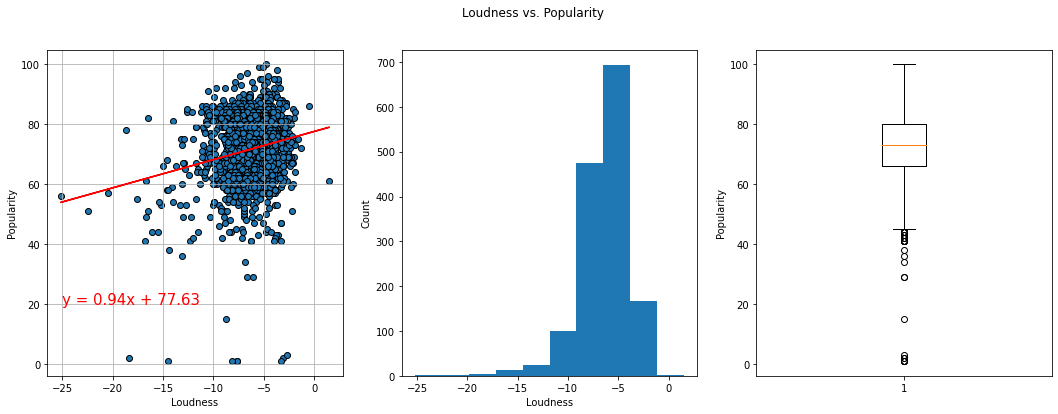


The r-value is: 0.2

---------------------------------------------------------------------

The mean Loudness is -6.35
The median Loudness is -6.02
The mode Loudness is ModeResult(mode=array([-6.66]), count=array([8]))

Disribution results for 50 samples for Loudness: NormaltestResult(statistic=0.6975844697868622, pvalue=0.705539701574512)

---------------------------------------------------------------------

The Loudness variance is approx. 6.25
The Loudness standard deviation is approx. 2.5
Roughly 68% of the data is between -8.85 and -3.85
Roughly 95% of the data is between -11.35 and -1.35
Roughly 99.7% of the data is between -13.85 and 1.15

---------------------------------------------------------------------

The lower quartile of Popularity is: 66.0
The upper quartile of Popularity is: 80.0
The interquartile range of Popularity is: 14.0
The the median of Popularity is: 73.0 
Values below 45.0 could be outliers.
Values above 101.0 could be outliers.


In [170]:
# Popularity vs. Loudness

# Calculate regression values and the line equation
reg_vals, ln_eq, r_val = calcLinregress(loudness ,popularity)

# Render the dashboard 
genereateDashboard(
    loudness, 
    popularity, 
    "Loudness", 
    "Popularity", 
    reg_vals, 
    ln_eq, 
    -25,
    20,
    f"{output_data_loc}/Loudness_vs_Popularity.png")

# Render the stats data report
generateStatsReport(r_val, loudness, popularity, "Loudness", "Popularity")
